In [1]:
import pandas as pd

In [68]:
# Читаем с тэгами и частотой использования в отзывах
hotels_df = pd.read_csv('data/hotels.csv')

In [69]:
# Делаем копию DF для более удобной работы
hotels = hotels_df.copy()

In [70]:
# перобразование категориальноого столбца с датой в тип дата
hotels['data'] = pd.to_datetime(hotels['review_date'])

In [71]:
# Создание признака год и квартал
hotels['year'] = hotels['data'].dt.year
hotels['quarter'] = hotels['data'].dt.quarter

In [72]:
hotels[['year', 'quarter']].head(2)

,year,quarter
0,2016,1
1,2017,1


In [73]:
# Кодирование года так как данные с самим годом плохо понимается системой обучения
hotels['year_col'] = 0
year = list(hotels['year'].unique())
year = sorted(year)

c = 1
map_win = {}
for x in year:
    map_win[x] = c
    c += 1
    
# Замена порядковых категориальных признаков методом map()
hotels['year_col'] = hotels['year'].map(map_win)

In [74]:
hotels['year_col'].head(2)

0    2
1    3
Name: year_col, dtype: int64

In [75]:
# Создание цыфрового признака дней отзыва
import re
days = []
for x in range(0, hotels.shape[0]):
    result = re.match(r'\d*', hotels['days_since_review'][x])
    days.append(int(result.group(0)))

hotels['days_since_review_int'] = days

In [76]:
hotels['days_since_review_int'].head(2)

0    531
1    203
Name: days_since_review_int, dtype: int64

In [77]:
# Двоичное кодирование признака страны отзыва
import category_encoders as ce # импорт для работы с кодировщиком
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(hotels['reviewer_nationality'])
hotels = pd.concat([hotels, type_bin], axis=1)

In [78]:
# Поиск пропусков
for l in hotels.columns:
    if hotels[l].isnull().sum() > 0:
        print(f'В колонке {l} {hotels[l].isnull().sum()} пропусков')

В колонке lat 2448 пропусков
В колонке lng 2448 пропусков


In [79]:
# Замена нулевых значений на среднее по столбцу
for l in hotels.columns:
    y = hotels[l].isnull().sum()
    if y > 0:
        hotels[l] = hotels[l].fillna(hotels[l].mean())

In [80]:
# Создание списков с цыфровыми столбцами
num_cols = []
list_d_type = ['int64', 'float64', 'int32']
for x in hotels.columns:
    if hotels[x].dtype in list_d_type:
        num_cols.append(x)

In [81]:
num_cols

['additional_number_of_scoring',
 'average_score',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'reviewer_score',
 'lat',
 'lng',
 'year',
 'quarter',
 'year_col',
 'days_since_review_int',
 'reviewer_nationality_0',
 'reviewer_nationality_1',
 'reviewer_nationality_2',
 'reviewer_nationality_3',
 'reviewer_nationality_4',
 'reviewer_nationality_5',
 'reviewer_nationality_6',
 'reviewer_nationality_7']

<!-- Проведём исследование, какие данные влияют на итоговый результат -->

In [82]:
# Для построения грайиков этих столбцов в списке быть не должно. Для оучения модели оны должны быть
num_cols.remove('reviewer_score')
num_cols.remove('lng')

In [83]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score'] 

<Axes: >

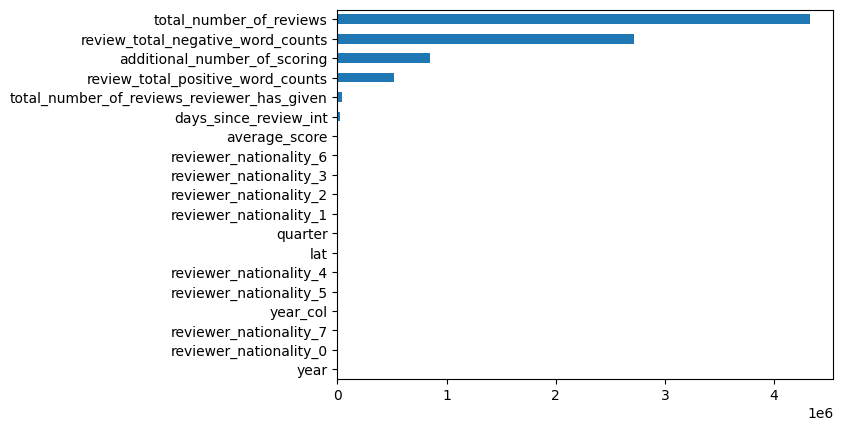

In [24]:
y=y.astype('int')

from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[num_cols], y)[0], index=num_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

По графику видно , что есть 4 колонки с самым большим влиянием на итоговый результат.

In [25]:
# Изменим масштаб убрав колонки с очень большими данными
num_cols.remove('total_number_of_reviews')
num_cols.remove('review_total_negative_word_counts')
num_cols.remove('additional_number_of_scoring')
num_cols.remove('review_total_positive_word_counts')
num_cols.remove('total_number_of_reviews_reviewer_has_given')
num_cols.remove('days_since_review_int')

<Axes: >

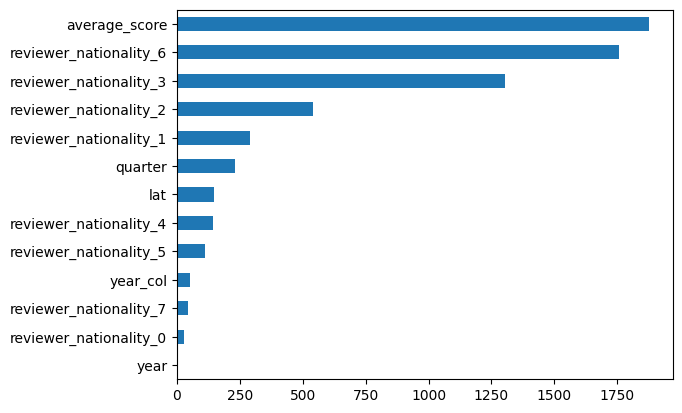

In [26]:
y=y.astype('int')

from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[num_cols], y)[0], index=num_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [27]:
num_cols.remove('average_score')
num_cols.remove('reviewer_nationality_6')
num_cols.remove('reviewer_nationality_3')
num_cols.remove('reviewer_nationality_2')

<Axes: >

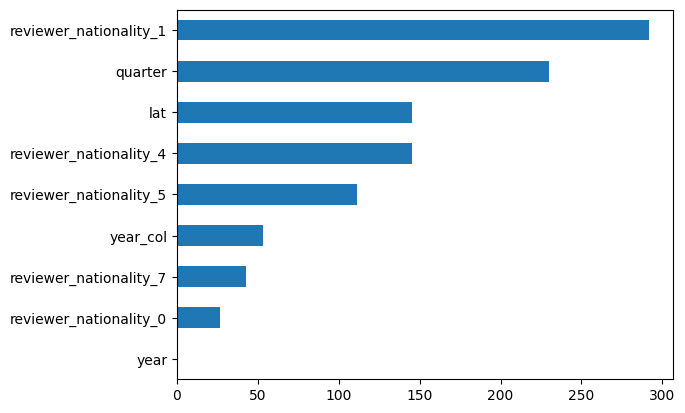

In [28]:
# Изменим масштаб убрав колонки с очень большими данными
y=y.astype('int')

from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[num_cols], y)[0], index=num_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [84]:
# Судя по графику колонка year абсолютно не влияет на итоговый результат.Удалим её
hotels = hotels.drop(['year'], axis=1)

In [30]:
hotels.columns

Index(['hotel_address', 'additional_number_of_scoring', 'review_date',
       'average_score', 'hotel_name', 'reviewer_nationality',
       'negative_review', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'positive_review',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 'tags',
       'days_since_review', 'lat', 'lng', 'data', 'quarter', 'year_col',
       'days_since_review_int', 'reviewer_nationality_0',
       'reviewer_nationality_1', 'reviewer_nationality_2',
       'reviewer_nationality_3', 'reviewer_nationality_4',
       'reviewer_nationality_5', 'reviewer_nationality_6',
       'reviewer_nationality_7'],
      dtype='object')

Библиотека анализа отзывов на положительный или отрицательный вариант

In [85]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import time
nltk.downloader.download('vader_lexicon')

sent_analyzer = SentimentIntensityAnalyzer()

# Создание цыфрового атрибута по негативному отзыву
sent_analyzer = SentimentIntensityAnalyzer()
neg = []
neu = []
pos = []
compound = []

for x in range(0, hotels.shape[0]):
    neg_rew = hotels['negative_review'][x]
    
    sent_a = sent_analyzer.polarity_scores(neg_rew)
    neg.append(list(sent_a.values())[0])
    neu.append(list(sent_a.values())[1])
    pos.append(list(sent_a.values())[2])
    compound.append(list(sent_a.values())[3])
    
hotels['negativ_rew_neg']=neg
hotels['negativ_rew_neu']=neu
hotels['negativ_rew_pos']=pos
hotels['negativ_rew_compound']=compound

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Major\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [86]:
# Создание цыфрового атрибута по позитивному отзыву
sent_analyzer = SentimentIntensityAnalyzer()
neg_p = []
neu_p = []
pos_p = []
compound_p = []

for x in range(0, hotels.shape[0]):
    neg_rew = hotels['positive_review'][x]
    sent_a = sent_analyzer.polarity_scores(neg_rew)
    
    neg_p.append(list(sent_a.values())[0])
    neu_p.append(list(sent_a.values())[1])
    pos_p.append(list(sent_a.values())[2])
    compound_p.append(list(sent_a.values())[3])
    
hotels['positiv_rew_neg']=neg_p
hotels['positiv_rew_neu']=neu_p
hotels['positiv_rew_pos']=pos_p
hotels['positiv_rew_compound']=compound_p

In [34]:
hotels.columns

Index(['hotel_address', 'additional_number_of_scoring', 'review_date',
       'average_score', 'hotel_name', 'reviewer_nationality',
       'negative_review', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'positive_review',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 'tags',
       'days_since_review', 'lat', 'lng', 'data', 'quarter', 'year_col',
       'days_since_review_int', 'reviewer_nationality_0',
       'reviewer_nationality_1', 'reviewer_nationality_2',
       'reviewer_nationality_3', 'reviewer_nationality_4',
       'reviewer_nationality_5', 'reviewer_nationality_6',
       'reviewer_nationality_7', 'negativ_rew_neg', 'negativ_rew_neu',
       'negativ_rew_pos', 'negativ_rew_compound', 'positiv_rew_neg',
       'positiv_rew_neu', 'positiv_rew_pos', 'positiv_rew_compound'],
      dtype='object')

In [113]:
# По Столбцу с тэгами характеристик отеля в отзывах tag тип данных строка,создадим столбц tag_1 в качестве значения список
hotels['tags_l'] = 0
for t in range(0, hotels.shape[0]):
    tag = []
    tag = hotels['tags'].iloc[t]
    tag = tag.split(',')
    tag = (x.replace("[' ", '') for x in tag)
    tag = (x.replace("']", '') for x in tag)
    tag = (x.replace("'", '') for x in tag)
    tag = (x.replace("'", '') for x in tag) 
    tag = [x[:-1] for x in tag]
    tag = [x.replace('  ', '') for x in tag]
    # if 'Submitted from a mobile device' in tag:
    #     tag.remove('Submitted from a mobile device')
    hotels['tags_l'].iloc[t] = tag

C:\Users\Asus1\AppData\Local\Temp\ipykernel_6656\1829528047.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotels['tags_l'].iloc[t] = tag


In [88]:
# Создание списка уникальных тэгов
# tags_col = []
# for x in hotels['tags_l']:
#     for y in x:
#         if y not in tags_col:
#             tags_col.append(y)

# tags_col.sort()

In [89]:
#  Создание колонки с количеством тэгов характеризирующих отель
hotels['tag_quantity'] = [len(x) for x in hotels['tags_l']]

In [90]:
hotels['tag_quantity']

0         5
1         4
2         5
3         4
4         4
         ..
386798    5
386799    5
386800    4
386801    4
386802    4
Name: tag_quantity, Length: 386803, dtype: int64

In [91]:
# чтение файла с данными по населению городов
df_city_word = pd.read_csv('data/world-city-listing-table_1.csv', sep=(','))

In [92]:
df_city_word.head(2)

,pop2023,pop2022,city,country,growthRate,type,rank,Unnamed: 7
0,37194105,37274002,Tokyo,Japan,-0.0021,w,1,NaN
1,32941309,32065760,Delhi,India,0.0273,w,2,NaN


In [ ]:
# Создание уникального списка городов отелей
city_hotel = []
for x in df_city_word['city']:
    for y in range(0, hotels.shape[0]):
        if x in hotels['hotel_address'][y]:
            if x not in city_hotel:
                city_hotel.append(x)


In [94]:
import json
with open('data/sity_hotel.json', 'r') as fp:
        # Чтение файла 'data.json' и преобразование
        # данных JSON в объекты Python 
    сity_hotel = json.load(fp)

In [95]:
city_hotel

['Buenos Aires',
 'Rio de Janeiro',
 'Paris',
 'Lima',
 'London',
 'Barcelona',
 'Sydney',
 'Rome',
 'Milan',
 'Manchester',
 'Tunis',
 'Valencia',
 'Vienna',
 'Lyon',
 'Medina',
 'Fes',
 'Sofia',
 'Amsterdam',
 'Lille',
 'Warri',
 'Jos',
 'Southampton',
 'Liverpool',
 'Charlotte',
 'Nottingham',
 'Hamilton',
 'Merca']

In [96]:
# Создание словаря с городами и населением
city_hotel_sl ={}
for x in city_hotel:
    city_hotel_sl[x] = df_city_word[df_city_word['city'] == x]['pop2022'].values[0]

In [97]:
city_hotel_sl

{'Buenos Aires': 15369919,
 'Rio de Janeiro': 13634274,
 'Paris': 11142303,
 'Lima': 11044607,
 'London': 9540576,
 'Barcelona': 5658472,
 'Sydney': 5056571,
 'Rome': 4297877,
 'Milan': 3149223,
 'Manchester': 2770434,
 'Tunis': 2439404,
 'Valencia': 1959318,
 'Vienna': 1960023,
 'Lyon': 1747575,
 'Medina': 1545420,
 'Fes': 1267317,
 'Sofia': 1286789,
 'Amsterdam': 1165898,
 'Lille': 1073395,
 'Warri': 942683,
 'Jos': 942167,
 'Southampton': 943745,
 'Liverpool': 911546,
 'Charlotte': 882681,
 'Nottingham': 800394,
 'Hamilton': 775751,
 'Merca': 727772}

In [98]:
# Заполнение колонки с городом
hotels['city'] = 0

for x in range(0, hotels.shape[0]):
    for s in sity_hotel:
        if s in hotels['hotel_address'][x]:
            hotels['city'][x] = s

C:\Users\Major\AppData\Local\Temp\ipykernel_11252\2856725862.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hotels['city'][x] = s


In [99]:
# Заполнение колонки с популяцией через map
hotels['population'] = hotels['city'].map(city_hotel_sl)

In [100]:
# Кодирование колонки с популяцией
population = list(hotels['population'].unique())
population = sorted(population)

c = 1
map_win = {}
for x in population:
    map_win[x] = c
    c += 1
    
# Замена порядковых категориальных признаков методом map()
hotels['population_col'] = hotels['population'].map(map_win)

In [101]:
# Двоичное кодирование признака города отеля
import category_encoders as ce # импорт для работы с кодировщиком
bin_encoder = ce.BinaryEncoder(cols=['city']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(hotels['city'])
hotels = pd.concat([hotels, type_bin], axis=1)

In [5]:
# Повторное создание списков с цыфровыми и категориальными столбцами для модели
cat_cols = []
num_cols = []
list_d_type = ['int64', 'float64']
for x in hotels.columns:
    if hotels[x].dtype in list_d_type:
        num_cols.append(x)

In [105]:
num_cols

['additional_number_of_scoring',
 'average_score',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'reviewer_score',
 'quarter',
 'year_col',
 'days_since_review_int',
 'reviewer_nationality_0',
 'reviewer_nationality_1',
 'reviewer_nationality_2',
 'reviewer_nationality_3',
 'reviewer_nationality_4',
 'reviewer_nationality_5',
 'reviewer_nationality_6',
 'reviewer_nationality_7',
 'negativ_rew_neg',
 'negativ_rew_neu',
 'negativ_rew_pos',
 'negativ_rew_compound',
 'positiv_rew_neg',
 'positiv_rew_neu',
 'positiv_rew_pos',
 'positiv_rew_compound',
 'tag_quantity',
 'population',
 'population_col',
 'city_0',
 'city_1',
 'city_2',
 'city_3',
 'city_4']

In [104]:
num_cols.remove('lat')
num_cols.remove('lng')

In [106]:
# Сортировка DF по цыфровым столбцам 
hotels = hotels[num_cols]

  # Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
    # Х — данные с информацией об отелях, у — целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score']  
      
    # Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  
      
    # Наборы данных с меткой "train" будут использоваться для обучения модели, "test" — для тестирования.  
    # Для тестирования мы будем использовать 25 % от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

  # Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
      
    # Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
    # Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
    # Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
    # Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)

print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12532064826182007


In [107]:
num_cols.remove('population')

In [108]:
# Сортировка DF по цыфровым столбцам 
hotels = hotels[num_cols]

  # Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
    # Х — данные с информацией об отелях, у — целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score']  
      
    # Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  
      
    # Наборы данных с меткой "train" будут использоваться для обучения модели, "test" — для тестирования.  
    # Для тестирования мы будем использовать 25 % от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

  # Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
      
    # Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
    # Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
    # Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
    # Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)

print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12528183485270475


In [2]:
# Читаем с тэгами и частотой использования в отзывах
hotels_df = pd.read_csv('data/hotels_itog.csv')

In [39]:
hotels = hotels_df.copy()

In [64]:
# Повторное создание списков с цыфровыми и категориальными столбцами для модели
cat_cols = []
num_cols = []
list_d_type = ['int64', 'float64']
for x in hotels.columns:
    if hotels[x].dtype in list_d_type:
        num_cols.append(x)

In [6]:
num_cols

['additional_number_of_scoring',
 'average_score',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'reviewer_score',
 'lat',
 'lng',
 'year',
 'quarter',
 'year_col',
 'days_since_review_int',
 'reviewer_nationality_0',
 'reviewer_nationality_1',
 'reviewer_nationality_2',
 'reviewer_nationality_3',
 'reviewer_nationality_4',
 'reviewer_nationality_5',
 'reviewer_nationality_6',
 'reviewer_nationality_7',
 'negativ_rew_neg',
 'negativ_rew_neu',
 'negativ_rew_pos',
 'negativ_rew_compound',
 'positiv_rew_neg',
 'positiv_rew_neu',
 'positiv_rew_pos',
 'positiv_rew_compound',
 'tag_quantity',
 'population',
 'population_col',
 'city_0',
 'city_1',
 'city_2',
 'city_3',
 'city_4']

In [4]:
hotels.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,tags_l,tag_quantity,city,population,population_col,city_0,city_1,city_2,city_3,city_4
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,...,"['Leisure trip', 'Couple', 'Studio Suite', 'St...",5,London,9540576,23,0,0,0,0,1
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,...,"['Business trip', 'Couple', 'Standard Double R...",4,Southampton,943745,8,0,0,0,1,0


In [ ]:
# поиск колонок с отрицательными значениями
for x in hotels_num.columns:
    for y in hotels_num[x]:
        if y < 0:
            print(x) 

In [73]:
hotels_num.columns

Index(['additional_number_of_scoring', 'average_score',
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'reviewer_score',
       'quarter', 'year_col', 'days_since_review_int',
       'reviewer_nationality_0', 'reviewer_nationality_1',
       'reviewer_nationality_2', 'reviewer_nationality_3',
       'reviewer_nationality_4', 'reviewer_nationality_5',
       'reviewer_nationality_6', 'reviewer_nationality_7', 'negativ_rew_neg',
       'negativ_rew_neu', 'negativ_rew_pos', 'positiv_rew_neg',
       'positiv_rew_neu', 'positiv_rew_pos', 'tag_quantity', 'population_col',
       'city_0', 'city_1', 'city_2', 'city_3', 'city_4'],
      dtype='object')

In [65]:
# Удаление колонок с малым весом на результат и одной колонки с отрицательными значениями для построения графика
num_cols_del = ['lat', 'lng', 'year', 'population', 'negativ_rew_compound', 'positiv_rew_compound']

for x in num_cols_del:
    num_cols.remove(x)

In [66]:
hotels_num = hotels[num_cols]

In [67]:
num_cols.remove('reviewer_score')

In [56]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels_num.drop(['reviewer_score'], axis = 1)  
y = hotels_num['reviewer_score'] 

<AxesSubplot:>

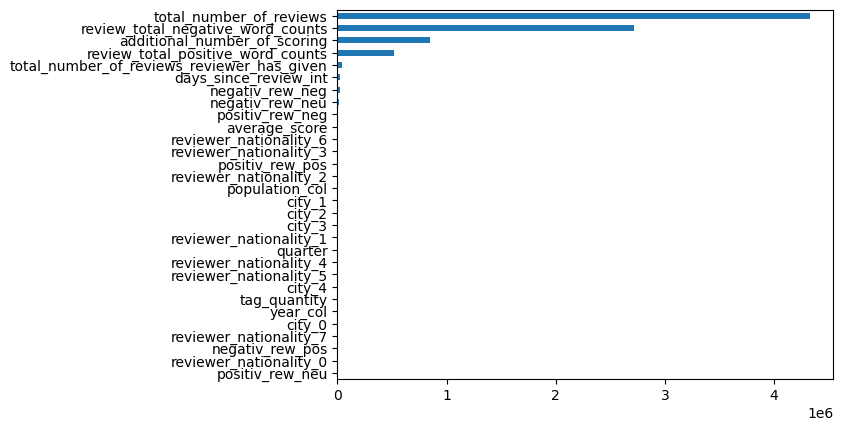

In [57]:
y=y.astype('int')

from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[num_cols], y)[0], index=num_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [68]:
# Изменим масштаб убрав колонки с очень большими данными
num_cols.remove('total_number_of_reviews')
num_cols.remove('review_total_negative_word_counts')
num_cols.remove('additional_number_of_scoring')
num_cols.remove('review_total_positive_word_counts')
num_cols.remove('total_number_of_reviews_reviewer_has_given')
num_cols.remove('days_since_review_int')

<AxesSubplot:>

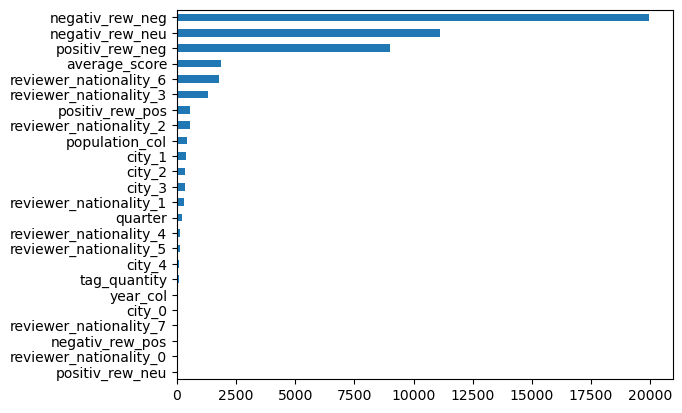

In [69]:
y=y.astype('int')

from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[num_cols], y)[0], index=num_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [70]:
num_cols.remove('negativ_rew_neg')
num_cols.remove('negativ_rew_neu')
num_cols.remove('positiv_rew_neg')
num_cols.remove('average_score')
num_cols.remove('reviewer_nationality_6')
num_cols.remove('reviewer_nationality_3')

<AxesSubplot:>

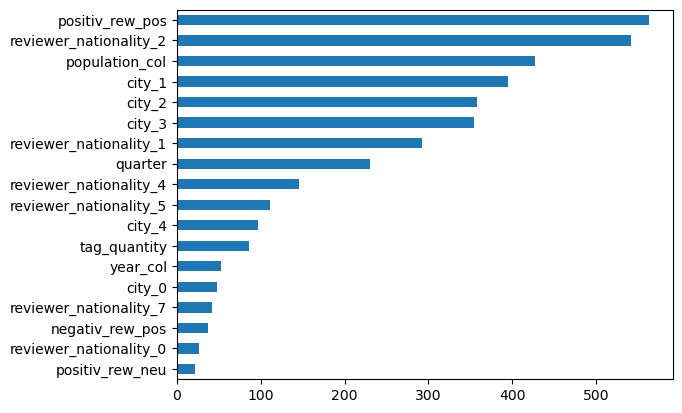

In [71]:
y=y.astype('int')

from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[num_cols], y)[0], index=num_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Согласно проведённому исследованию , половина данных в DF очень мало влияет на итоговый результат. 

In [91]:
# Создание цыфрового атрибута по названию отеля
sent_analyzer = SentimentIntensityAnalyzer()
# neg_emo = []
neu_emo = []
pos_emo = []
compound_emo = []

for x in hotels['hotel_name']:
    sent_a = sent_analyzer.polarity_scores(x)
    
    # neg_emo.append(list(sent_a.values())[0])
    neu_emo.append(list(sent_a.values())[1])
    pos_emo.append(list(sent_a.values())[2])
    compound_emo.append(list(sent_a.values())[3])
    
hotels['emo_hotel_name_neu']=neu_emo
hotels['emo_hotel_name_pos']=pos_emo
hotels['emo_hotel_name_compound']=compound_emo

In [92]:
# Создание цыфрового атрибута по имени адреса отеля
sent_analyzer = SentimentIntensityAnalyzer()
# neg_emo = []
neu_emo_adr = []
pos_emo_adr = []
compound_emo_adr = []

for x in hotels['hotel_address']:
    sent_a = sent_analyzer.polarity_scores(x)
    
    # neg_emo.append(list(sent_a.values())[0])
    neu_emo_adr.append(list(sent_a.values())[1])
    pos_emo_adr.append(list(sent_a.values())[2])
    compound_emo_adr.append(list(sent_a.values())[3])
    
hotels['emo_hotel_address_neu']=neu_emo_adr
hotels['emo_hotel_address_pos']=pos_emo_adr
hotels['emo_hotel_address_compound']=compound_emo_adr

In [132]:
# Повторное создание списков с цыфровыми и категориальными столбцами для модели
cat_cols = []
num_cols = []
list_d_type = ['int64', 'float64']
for x in hotels.columns:
    if hotels[x].dtype in list_d_type:
        num_cols.append(x)

In [133]:
# Удаление колонок с малым весом на результат и одной колонки с отрицательными значениями для построения графика
num_cols_del = ['lat', 'lng', 'year', 'population', 'negativ_rew_compound', 'positiv_rew_compound']

for x in num_cols_del:
    num_cols.remove(x)

In [134]:
hotels_num = hotels[num_cols]
num_cols.remove('reviewer_score')

In [135]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels_num.drop(['reviewer_score'], axis = 1)  
y = hotels_num['reviewer_score'] 

In [136]:
# Изменим масштаб убрав колонки с очень большими и отрицательными данными 
num_cols.remove('total_number_of_reviews')
num_cols.remove('review_total_negative_word_counts')
num_cols.remove('additional_number_of_scoring')
num_cols.remove('review_total_positive_word_counts')
num_cols.remove('total_number_of_reviews_reviewer_has_given')
num_cols.remove('days_since_review_int')
num_cols.remove('emo_hotel_name_compound')
num_cols.remove('emo_hotel_address_compound')
num_cols.remove('negativ_rew_neg')
num_cols.remove('negativ_rew_neu')
num_cols.remove('positiv_rew_neg')
num_cols.remove('average_score')
num_cols.remove('reviewer_nationality_6')
num_cols.remove('reviewer_nationality_3')

In [ ]:
# поиск колонок с отрицательными значениями
for x in hotels_num.columns:
    for y in hotels_num[x]:
        if y < 0:
            print(x) 

<AxesSubplot:>

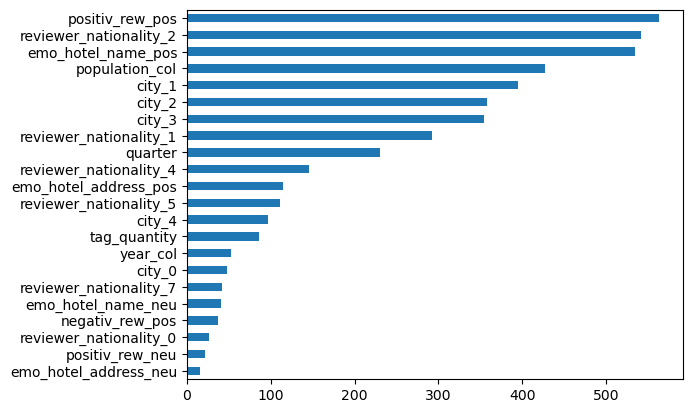

In [137]:
y=y.astype('int')

from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[num_cols], y)[0], index=num_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Согласно проведённому исследованию атрибуты созданные с помощью модуля по эмоциональному содержанию названия иадреса отелей имеют очень мплое влияние на итоговы результат. Но всё же влияют

In [138]:
# Повторное создание списков с цыфровыми и категориальными столбцами для модели
cat_cols = []
num_cols = []
list_d_type = ['int64', 'float64']
for x in hotels.columns:
    if hotels[x].dtype in list_d_type:
        num_cols.append(x)

In [139]:
num_cols

['additional_number_of_scoring',
 'average_score',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'reviewer_score',
 'lat',
 'lng',
 'year',
 'quarter',
 'year_col',
 'days_since_review_int',
 'reviewer_nationality_0',
 'reviewer_nationality_1',
 'reviewer_nationality_2',
 'reviewer_nationality_3',
 'reviewer_nationality_4',
 'reviewer_nationality_5',
 'reviewer_nationality_6',
 'reviewer_nationality_7',
 'negativ_rew_neg',
 'negativ_rew_neu',
 'negativ_rew_pos',
 'negativ_rew_compound',
 'positiv_rew_neg',
 'positiv_rew_neu',
 'positiv_rew_pos',
 'positiv_rew_compound',
 'tag_quantity',
 'population',
 'population_col',
 'city_0',
 'city_1',
 'city_2',
 'city_3',
 'city_4',
 'emo_hotel_name_neu',
 'emo_hotel_name_pos',
 'emo_hotel_name_compound',
 'emo_hotel_address_neu',
 'emo_hotel_address_pos',
 'emo_hotel_address_compound']

In [140]:
# Из списка цыфровых колоно удалим эти так как они отрицательно влияют на конечный результат
num_cols.remove('population')
num_cols.remove('lat')
num_cols.remove('lng')
num_cols.remove('year')

In [141]:
# Сортировка DF по цыфровым столбцам 
hotels = hotels[num_cols]

  # Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
    # Х — данные с информацией об отелях, у — целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score']  
      
    # Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  
      
    # Наборы данных с меткой "train" будут использоваться для обучения модели, "test" — для тестирования.  
    # Для тестирования мы будем использовать 25 % от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

  # Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
      
    # Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
    # Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
    # Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
    # Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)

print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12529251891965498


In [125]:
# # Сохранение DF в csv с тэгами и частотой использования в отзывах
hotels.to_csv('data/hotels_itog_1.csv', index=False)

In [126]:
# Читаем с тэгами и частотой использования в отзывах
hotels_df = pd.read_csv('data/hotels_itog_1.csv')

In [127]:
# Делаем копию DF для более удобной работы
hotels = hotels_df.copy()